# Laboratory work #2 (n-grams)

In [2]:
import os


import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import re
from nltk.util import ngrams
from nltk.corpus import stopwords
from collections import Counter

import math
from nltk.probability import FreqDist
from nltk.collocations import TrigramCollocationFinder, TrigramAssocMeasures

import matplotlib.pyplot as plt
from pandas.errors import EmptyDataError

[nltk_data] Downloading package punkt to /home/azureuser/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
def read_files(root_dir, n=None):
    file_paths = []

    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.tsv'):
                file_paths.append(os.path.join(subdir, file))

    all_data = []
    for i, file_path in enumerate(file_paths):
        if n is not None and i >= n:
            break
        try:
            rows = []
            sentence_index = 0

            with open(file_path, 'r') as file:
                for line in file:
                    line = line.strip()
                    if line:
                        token, stem, lemma = line.split('\t')
                        rows.append({'Token': token, 'Stem': stem, 'Lemma': lemma, 'Sentence_Index': sentence_index})
                    else:
                        sentence_index += 1

            file_data = pd.DataFrame(rows)
            if len(file_data) >= 1:
                all_data.append(file_data)
        except EmptyDataError as e:
            print(i, file_path, e)
    ids = [os.path.splitext(os.path.basename(path))[0] for path in file_paths]
    return ids, all_data


In [4]:
train_ids, train = read_files('../assets/annotated-corpus/train', 
                #    1000
                   )
# val_ids, val = read_files('../assets/annotated-corpus/val', 
#                 #  100
#                  )
test_ids, test = read_files('../assets/annotated-corpus/test', 
                #   100
                  )

In [5]:
train[1].head(40)

,Token,Stem,Lemma,Sentence_Index
0,Freedom,freedom,Freedom,0
1,is,is,is,0
2,not,not,not,0
3,a,a,a,0
4,gift,gift,gift,0
5,from,from,from,0
6,government,govern,government,0
7,.,.,.,0
8,It,it,It,1
9,is,is,is,1


In [6]:
len(train)

30916

In [7]:
def get_n_gram_freq(df_list, language='english'):
    stop_words = set(stopwords.words(language))
    
    n_grams = []
    for df in df_list:
        try:
            stems = df['Stem'].apply(lambda x: re.sub(r'[^\w\s]', '', x)).str.lower()
            stems = [stem for stem in stems if stem not in stop_words and stem.strip() != '']
            trigrams = list(ngrams(stems, 3))
            n_grams.extend(trigrams)
        except:
            print('error with df:')
            print(df)

    n_gram_freq = Counter(n_grams)
    return n_gram_freq

In [8]:
train_freq = get_n_gram_freq(train)

In [9]:
train_freq

Counter({('usa', 'today', 'publish'): 1,
         ('today', 'publish', 'articl'): 1,
         ('publish', 'articl', 'today'): 2,
         ('articl', 'today', 'egregi'): 1,
         ('today', 'egregi', 'mislead'): 1,
         ('egregi', 'mislead', 'everi'): 1,
         ('mislead', 'everi', 'hotel'): 1,
         ('everi', 'hotel', 'leav'): 1,
         ('hotel', 'leav', 'joke'): 1,
         ('leav', 'joke', 'public'): 1,
         ('joke', 'public', 'outsid'): 1,
         ('public', 'outsid', 'door'): 1,
         ('outsid', 'door', 'guest'): 1,
         ('door', 'guest', 'read'): 1,
         ('guest', 'read', 'asham'): 1,
         ('read', 'asham', 'peddl'): 1,
         ('asham', 'peddl', 'trash'): 1,
         ('peddl', 'trash', 'even'): 1,
         ('trash', 'even', 'free'): 1,
         ('even', 'free', 'know'): 1,
         ('free', 'know', 'say'): 1,
         ('know', 'say', 'free'): 1,
         ('say', 'free', 'free'): 1,
         ('free', 'free', 'reason'): 1,
         ('free', 'reason

In [10]:
def calculate_MI(n_grams, total_words, word_freq):
    mi_scores = {}
    for n_gram in n_grams:
        p_n_gram = n_grams[n_gram]
        p_w1 = word_freq[n_gram[0]]
        p_w2 = word_freq[n_gram[1]] 

        mi_score = math.log2(p_n_gram * pow(total_words, 2) / (p_w1 * p_w2))
        mi_scores[n_gram] = mi_score
    return mi_scores


def get_mi_scores(freq):
    total_words = sum(freq.values())
    word_freq = FreqDist(word for trigram in freq for word in trigram)
    mi_scores = calculate_MI(freq, total_words, word_freq)
    return mi_scores


def get_mi_scores_nltk(df_list, language='english'):
    stop_words = set(stopwords.words(language))
    full_text = ''
    
    for df in df_list:
        try:
            words = df['Stem'].apply(lambda x: re.sub(r'[^\w\s]', '', x)).str.lower()
            words = [word for word in words if word not in stop_words and word.strip() != '']
            full_text += ' '.join(words)
        except:
            print('error with df:')
            print(df)
        
    tokens = nltk.word_tokenize(full_text, language, True)
    text = nltk.Text(tokens)
        
    trigram_measures = TrigramAssocMeasures()
    finder = TrigramCollocationFinder.from_words(text)
    nltk_mi_scores = finder.score_ngrams(trigram_measures.pmi)
    return nltk_mi_scores

In [11]:
train_mi_scores = get_mi_scores(train_freq)

In [12]:
train_mi_scores_nltk = get_mi_scores_nltk(train)

In [13]:
n = 30
sorted_mi_scores = sorted(train_mi_scores.items(), key=lambda x: x[1], reverse=True)[:n]
print(f'Top {n} trigrams MI:')
for trigram, score in sorted_mi_scores:
    print(f'{trigram}: {score}')

Top 30 trigrams MI:
('parentnod', 'insertbefor', 'js'): 46.07410840173732
('en_us', 'sdk', 'js'): 45.91567903913284
('xfbml1038versionv23', 'fjs', 'parentnod'): 45.813580851514104
('moralist', 'masochist', 'street'): 44.93643759929964
('lovabl', 'rascal', 'join'): 44.93643759929964
('fjs', 'getelementsbytagnam', '0'): 44.84005306287529
('afshin', 'rattan', 'goe'): 44.6209357735717
('iiiiiitttt', 'ssssssss', 'wonder'): 44.6209357735717
('merkellegaci', 'pictwittercomwbh5cjj2iw', 'jame'): 44.6209357735717
('170619', 'naa175092', 'san'): 44.6209357735717
('hahahahahahahaha', 'hahahahahahahahahahahahahahahahahaahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahaha', 'hah'): 44.6209357735717
('ownag', 'pictwittercomyznlkcyimw', 'paul'): 44.6209357735717
('js', 'xfbml1038versionv23', 'fjs'): 44.59118843017765
('marinucci', 'cmarinucci', 'may'): 44.45101077212939
('zaru', 'deena_cnn', 'decemb'): 44.45101077212939
('westpfahl', 'markjwestpfahl', 'decemb'): 44.451010772

In [14]:
n = 30
sorted_mi_scores = sorted(train_mi_scores.items(), key=lambda x: x[1], reverse=False)
print(f'Last top {n} trigrams MI:')
for trigram, score in sorted_mi_scores[:n]:
    print(f'{trigram}: {score}')

Last top 30 trigrams MI:
('said', 'said', 'class'): 10.29274963870242
('said', 'said', 'coupl'): 10.29274963870242
('said', 'said', 'said'): 10.29274963870242
('said', 'said', 'certain'): 10.29274963870242
('said', 'said', 'plot'): 10.29274963870242
('said', 'said', 'definit'): 10.29274963870242
('said', 'said', 'touch'): 10.29274963870242
('said', 'said', 'open'): 10.29274963870242
('said', 'said', 'flight'): 10.29274963870242
('said', 'said', 'matt'): 10.29274963870242
('said', 'said', 'meant'): 10.29274963870242
('said', 'said', 'multipl'): 10.29274963870242
('said', 'said', 'excus'): 10.29274963870242
('said', 'said', 'democrat'): 10.29274963870242
('said', 'said', 'mobil'): 10.29274963870242
('said', 'said', 'leav'): 10.29274963870242
('said', 'said', 'comput'): 10.29274963870242
('said', 'said', 'day'): 10.29274963870242
('said', 'said', 'tweet'): 10.29274963870242
('said', 'said', 'give'): 10.29274963870242
('said', 'said', 'benghazi'): 10.29274963870242
('said', 'said', 'learn'

In [15]:
print(f'Top {n} trigrams MI with nltk:')
for trigram, score in train_mi_scores_nltk[:n]:
    print(f'{trigram}: {score}')

Top 30 trigrams MI with nltk:
('01000110', '01010101', 'hitman0321'): 45.63416638868411
('114rosi', '73kim', '56liz'): 45.63416638868411
('1278bett', '484ruth', '314megyn'): 45.63416638868411
('12day', 'bostoncollegerac', 'cjbc'): 45.63416638868411
('14pm', 'pdtread', 'bprgari'): 45.63416638868411
('173cher', '114rosi', '73kim'): 45.63416638868411
('1746', 'kadi', 'letoksi'): 45.63416638868411
('1892', 'mahlon', 'pitney'): 45.63416638868411
('2016robert', 'fantina', 'counterpunchalthough'): 45.63416638868411
('2016squar', 'funrectangl', 'mehtriangl'): 45.63416638868411
('2017hahahahahahahahahahahahahahahahahahahahahahahahahahahahahayou', 'refuckedhahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahaha', 'blanketi'): 45.63416638868411
('2170', '2178', '2199'): 45.63416638868411
('314megyn', '173cher', '114rosi'): 45.63416638868411
('484ruth', '314megyn', '173cher'): 45.63416638868411
('55yearsoldcleavagesolidaritypictwittercomtaegzkmcmz', 'janey', 'godley'): 45.634166388684

In [16]:
nltk_mi_dict = dict(train_mi_scores_nltk)

matched_mi_scores = []

for trigram, mi_score in sorted_mi_scores:
    if trigram in nltk_mi_dict:
        matched_mi_scores.append((trigram, mi_score, nltk_mi_dict[trigram]))

# for trigram, own_mi, nltk_mi in matched_mi_scores:
#     print(f'Trigram: {trigram}, My MI: {own_mi}, NLTK MI: {nltk_mi}')

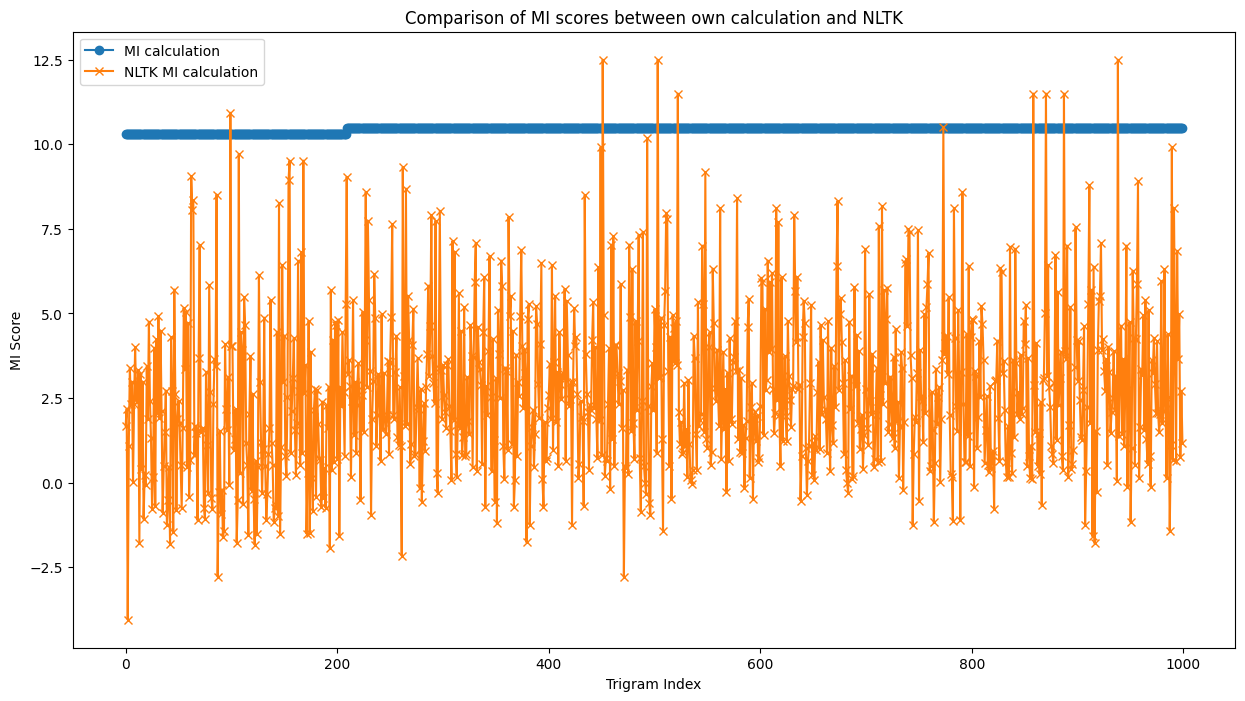

In [17]:
df = pd.DataFrame(matched_mi_scores, columns=['Trigram', 'MI', 'NLTK_MI']).iloc[:1000, :]
x_indexes = range(len(df))

plt.figure(figsize=(15, 8))
plt.plot(x_indexes, df['MI'], label='MI calculation', marker='o')
plt.plot(x_indexes, df['NLTK_MI'], label='NLTK MI calculation', marker='x')

plt.xlabel('Trigram Index')
plt.ylabel('MI Score')
plt.title('Comparison of MI scores between own calculation and NLTK')

plt.legend()
plt.show()

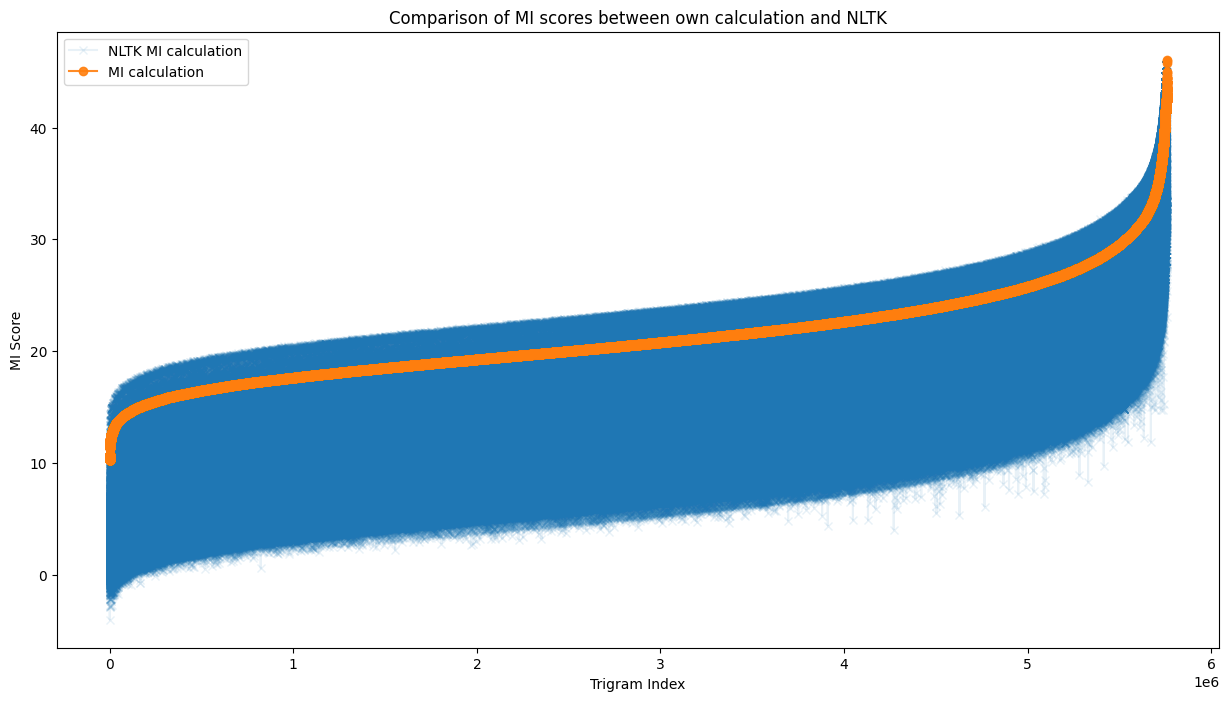

In [27]:
df = pd.DataFrame(matched_mi_scores, columns=['Trigram', 'MI', 'NLTK_MI'])
x_indexes = range(len(df))

plt.figure(figsize=(15, 8))
plt.plot(x_indexes, df['NLTK_MI'], label='NLTK MI calculation', marker='x', alpha=0.1)
plt.plot(x_indexes, df['MI'], label='MI calculation', marker='o', alpha=0.9)

plt.xlabel('Trigram Index')
plt.ylabel('MI Score')
plt.title('Comparison of MI scores between own calculation and NLTK')

plt.legend()
plt.show()

In [22]:
df.head()

,Trigram,MI,NLTK_MI
0,"(said, said, class)",10.29275,1.684869
1,"(said, said, coupl)",10.29275,2.180644
2,"(said, said, said)",10.29275,-4.046384
3,"(said, said, certain)",10.29275,1.092786
4,"(said, said, plot)",10.29275,3.394858


In [24]:
df.sample(10)

,Trigram,MI,NLTK_MI
5728339,"(jamil, jaffer, republican)",36.714045,24.775117
1328568,"(high, inform, lectur)",18.207645,12.910462
3451455,"(drink, name, like)",21.543736,10.021440
1650248,"(later, legisl, stumbl)",18.717547,14.522528
2249978,"(choic, base, gender)",19.624293,12.668340
374260,"(chang, becaus, allow)",16.046858,6.116836
4697236,"(fsb, interest, legal)",24.539383,14.970899
1101711,"(administr, justic, guilti)",17.811279,9.921903
556861,"(week, statement, messag)",16.623840,7.221811
1020616,"(go, explain, go)",17.656504,6.460126
